In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame, Index, Series, concat
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm


# Refactor Ideal Engagement Order

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='',
    category_history_df='', Correct_order_of_FIRST11=''
)
triage_paper_df = data_frames_list['first_responder_master_registry_df']
file_stats_df = data_frames_list['first_responder_master_registry_file_stats_df']
scene_stats_df = data_frames_list['first_responder_master_registry_scene_stats_df']
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df, file_stats_df, scene_stats_df,
    needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'session_file_date']
)
Correct_order_of_FIRST11_df = data_frames_list['Correct_order_of_FIRST11']
engagement_dict = {patient_str + ' Root': group_id for (patient_str, group_id), patient_group_df in Correct_order_of_FIRST11_df.groupby(['Patient', 'Group'])}
first11_patients_list = [p + ' Root' for p in Correct_order_of_FIRST11_df.Patient]
first11_df = elevens_df.groupby(fu.scene_groupby_columns).filter(
    lambda scene_df: scene_df[~scene_df.patient_id.isnull()].patient_id.isin(first11_patients_list).all()
)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_file_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_scene_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/category_history_df.pkl.
No csv exists for Correct_order_of_FIRST11 - trying /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/data/csv/Correct_order_of_FIRST11.csv.


In [4]:

# Test all the methods used in this notebook in one test suite
import unittest
if ('../tests' not in sys.path): sys.path.insert(1, '../tests')
suite = unittest.TestSuite()

# Add all test cases from each class to the suite
from test_notebook_utils_ordering_functions import (
    TestCountSwapsToPerfectOrder
)
suite.addTest(unittest.makeSuite(TestCountSwapsToPerfectOrder))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [5]:

engagement_dict

{'Bob_0 Root': 1, 'Bob_9 Root': 3, 'Gary_1 Root': 1, 'Gary_3 Root': 1, 'Gloria_6 Root': 2, 'Gloria_8 Root': 3, 'Helga_10 Root': 3, 'Lily_2 Root': 1, 'Lily_4 Root': 1, 'Mike_5 Root': 1, 'Mike_7 Root': 1}

In [36]:

from scipy.stats import kendalltau

rows_list = []
for (session_uuid, scene_id), scene_df in first11_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_sequences(scene_df)
    if pd.isna(actual_sequence).all(): continue
    row_dict = nu.get_row_dictionary(actual_sequence.tolist(), row_dict=row_dict, key_prefix='actual_sequence')
    row_dict = nu.get_row_dictionary(ideal_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_sequence')
    
    engagement_order = fu.get_actual_engagement_order(scene_df)
    engagement_order_dicts_list = [
        {
            'patient_id': engagement_tuple[0],
            'engagement_start': engagement_tuple[1],
            'location_tuple': engagement_tuple[2],
            'patient_sort': engagement_tuple[3],
            'predicted_priority': engagement_tuple[4],
            'injury_severity': engagement_tuple[5]
        } for engagement_tuple in engagement_order
    ]
    row_dict = nu.get_row_dictionary(engagement_order_dicts_list, row_dict=row_dict, key_prefix='engagement_order')
    
    actual_patient_sequence = Series([engagement_dict.get(engagement_tuple[0]) for engagement_tuple in engagement_order])
    row_dict = nu.get_row_dictionary(actual_patient_sequence.tolist(), row_dict=row_dict, key_prefix='actual_patient_sequence')
    
    ideal_patient_sequence = actual_patient_sequence.sort_values(ascending=True)
    row_dict = nu.get_row_dictionary(ideal_patient_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_patient_sequence')
    
    measure_of_ordering = fu.get_measure_of_ordering(actual_patient_sequence, ideal_patient_sequence)
    row_dict['measure_of_ordering'] = measure_of_ordering

    swaps_to_perfect_order = nu.count_swaps_to_perfect_order(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['swaps_to_perfect_order'] = swaps_to_perfect_order
    
    # Calculate Kendall's tau coefficient
    tau, p_value = kendalltau(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['kendall_tau_coefficient'] = tau
    
    rows_list.append(row_dict)
measure_of_ordering_df = DataFrame(rows_list)

In [37]:

measure_of_ordering_df.sort_values('kendall_tau_coefficient').head(5).dropna(axis='columns', how='all').T

,28,17,11,37,29
session_uuid,991af001-9414-4a2d-8079-0663c4ddb1e4,38b995b3-fb77-4fda-b0b4-21f062ed6a38,26f08763-076e-4531-a6f7-f00232f664bd,b1ebfdc9-6338-4b80-ba76-947f8690bd91,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13
scene_id,0,0,0,0,1
actual_sequence00,54837.0,65654.0,30996.0,48140.0,261333.0
actual_sequence01,56460.0,69168.0,39071.0,87445.0,262646.0
actual_sequence02,78736.0,126165.0,84011.0,165001.0,276234.0
...,...,...,...,...,...
ideal_patient_sequence4,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence5,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence6,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence7,NaN,NaN,2.0,NaN,NaN


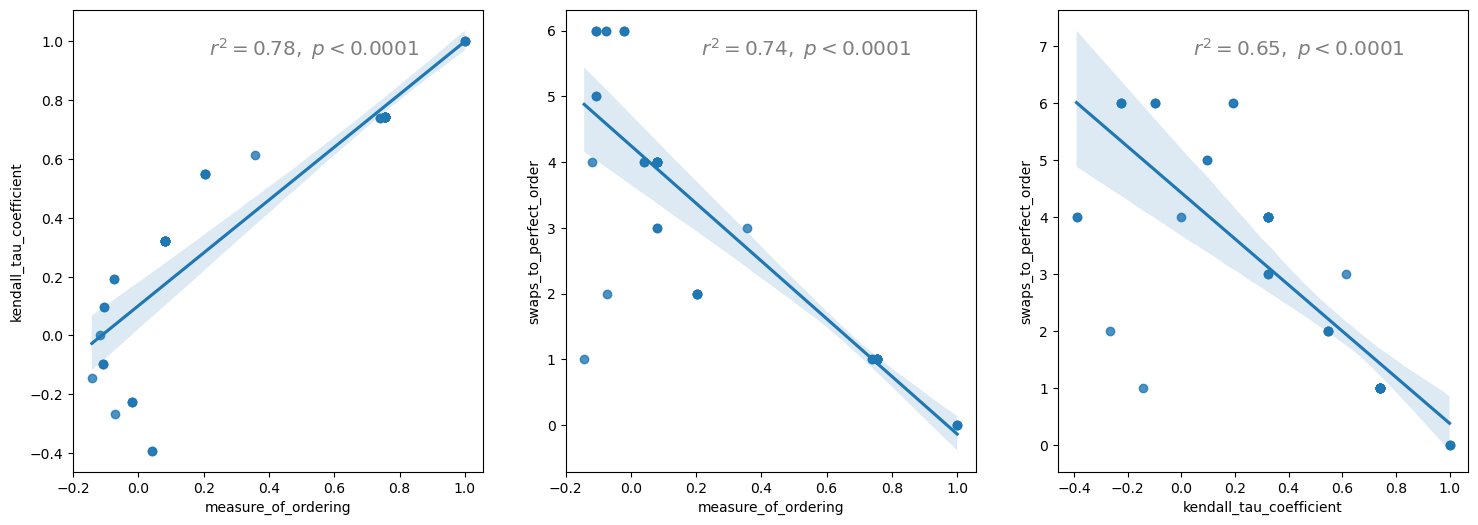

In [50]:

from itertools import combinations
import seaborn as sns

columns_list = ['measure_of_ordering', 'kendall_tau_coefficient', 'swaps_to_perfect_order']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i, list_pair in enumerate(combinations(columns_list, 2)):
    _ = sns.regplot(x=list_pair[0], y=list_pair[1], scatter=True, data=measure_of_ordering_df, ax=axes[i])
    
    # Annotate r squared value
    s_str = nu.get_r_squared_value_latex(measure_of_ordering_df[list_pair[0]], measure_of_ordering_df[list_pair[1]])
    text_tuple = axes[i].text(0.33, 0.9, s_str, alpha=0.5, transform=axes[i].transAxes, fontsize='x-large')

In [52]:

for cn in columns_list: display(fu.get_statistics(measure_of_ordering_df, [cn]))

,measure_of_ordering
mean,0.318178
mode,0.755168
median,0.080152
SD,0.389143
min,-0.142857
25%,-0.019441
50%,0.080152
75%,0.755168
max,1.000000


,kendall_tau_coefficient
mean,0.387076
mode,0.741935
median,0.322581
SD,0.395543
min,-0.391304
25%,0.096774
50%,0.322581
75%,0.741935
max,1.000000


,swaps_to_perfect_order
mean,2.854167
mode,1.000000
median,2.500000
SD,1.989222
min,0.000000
25%,1.000000
50%,2.500000
75%,4.000000
max,6.000000


In [5]:

distracted_sequence = Series([engagement_dict.get(engagement_tuple[0]) for engagement_tuple in fu.get_distracted_engagement_order(scene_df)])
fu.get_measure_of_ordering(actual_sequence, distracted_sequence)

-0.019440671998390613

In [7]:

input_features = [
    'injury_id', 'injury_severity', 'injury_required_procedure', 'patient_salt', 'patient_sort', 'patient_pulse', 'patient_breath',
    'patient_hearing', 'patient_mood', 'patient_pose'
    ]

In [39]:

ml_columns = ['lr_triage_priority_model_prediction', 'dtr_triage_priority_model_prediction']
stats_column_name = 'stats_type'
stats_columns_list = fu.scene_groupby_columns + ['patient_id', stats_column_name] + ml_columns
scene_stats_df = DataFrame([], columns=stats_columns_list)
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):

    # Create the patient sort tuples list
    engagement_starts_list = []
    patient_stats_df = DataFrame([], columns=stats_columns_list)
    for patient_id, patient_df in scene_df.groupby('patient_id'):

        # Get the cluster ID, if available
        mask_series = ~patient_df.patient_sort.isnull()
        patient_sort = (
            patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
            if mask_series.any():
            else None
        )

        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():

            # Get the list of engagements as action ticks
            engagements_list = patient_df[mask_series].action_tick
            mask_series = patient_df.action_tick.isin(engagements_list) & ~patient_df.location_id.isnull()
            if mask_series.any():
                df = patient_df[mask_series].sort_values('action_tick')

                # Get the first engagement start and location
                engagement_start = df.iloc[0].action_tick
                engagement_location = eval(df.iloc[0].location_id) # Evaluate string to get tuple
                location_tuple = (engagement_location[0], engagement_location[2])

                # Add engagement information to the list
                engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort)
                engagement_starts_list.append(engagement_tuple)
                
                # Get the patient stats
                df = nu.get_statistics(patient_df, ml_columns).reset_index(drop=False).rename(columns={'index': stats_column_name})
                for cn in fu.scene_groupby_columns: df[cn] = eval(cn)
                df['patient_id'] = patient_id
                df = df[stats_columns_list]
                
                # Append the data frame for the current patient to the stats data frame
                patient_stats_df = concat([patient_stats_df, df], axis='index').reset_index(drop=True)

    # Sort the starts list chronologically
    actual_engagement_order = sorted(engagement_starts_list, key=lambda x: x[1], reverse=False)
    engagement_starts_dict = {patient_id: engagement_start for patient_id, engagement_start, location_tuple, patient_sort in actual_engagement_order}
    
    # Calculate the R-squared adjusted value as a measure of derived ordering
    y = Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    max_measure = -2
    max_stats_type = 'stats_type'
    max_ml_column = 'ml_column'
    max_ascending = 'ascending'
    for stats_type in patient_stats_df.stats_type.unique():
        mask_series = (patient_stats_df.stats_type == stats_type)
        for ml_column in ml_columns:
            for ascending in [True, False]:
                derived_engagement_order = patient_stats_df[mask_series].sort_values(ml_column, ascending=ascending).patient_id.tolist()
                X = Series([engagement_starts_dict[patient_id] for patient_id in derived_engagement_order]).values.reshape(-1, 1)
                if X.shape[0]:
                    X1 = sm.add_constant(X)
                    try:
                        measure_of_derived_ordering = sm.OLS(y, X1).fit().rsquared_adj
                        if (max_measure < measure_of_derived_ordering):
                            max_measure = measure_of_derived_ordering
                            max_stats_type = stats_type
                            max_ml_column = ml_column
                            max_ascending = ascending
                    except: continue
    patient_stats_df['max_measure'] = max_measure
    patient_stats_df['max_stats_type'] = max_stats_type
    patient_stats_df['max_ml_column'] = max_ml_column
    patient_stats_df['max_ascending'] = max_ascending
    
    # Append the data frame for the current patient to the stats data frame
    scene_stats_df = concat([scene_stats_df, patient_stats_df], axis='index').reset_index(drop=True)

In [51]:

mask_series = (scene_stats_df.max_measure == 1.0)
display(scene_stats_df[mask_series].max_stats_type.value_counts())

mean    837
25%     432
SD      378
max     261
mode    171
min      45
75%      36
Name: max_stats_type, dtype: int64

In [57]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
display(scene_stats_df[mask_series].max_ml_column.value_counts())

dtr_triage_priority_model_prediction    630
lr_triage_priority_model_prediction     207
Name: max_ml_column, dtype: int64

In [58]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
mask_series &= (scene_stats_df.max_ml_column == 'dtr_triage_priority_model_prediction')
display(scene_stats_df[mask_series].max_ascending.value_counts())

True     522
False    108
Name: max_ascending, dtype: int64

In [61]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
mask_series &= (scene_stats_df.max_ml_column == 'dtr_triage_priority_model_prediction')
mask_series &= scene_stats_df.max_ascending
columns_list = [
    'patient_id', 'stats_type', 'lr_triage_priority_model_prediction', 'dtr_triage_priority_model_prediction'
]
display(scene_stats_df[mask_series][columns_list])

,patient_id,stats_type,lr_triage_priority_model_prediction,dtr_triage_priority_model_prediction
5868,Mike_0 Root,mean,7.081984,7.375000
5869,Mike_0 Root,mode,8.623898,9.000000
5870,Mike_0 Root,median,8.623898,9.000000
5871,Mike_0 Root,SD,2.075794,2.939736
5872,Mike_0 Root,min,3.926232,2.500000
...,...,...,...,...
41692,Mike_3 Root,min,5.734049,8.000000
41693,Mike_3 Root,25%,6.206855,8.000000
41694,Mike_3 Root,50%,8.623898,9.000000
41695,Mike_3 Root,75%,8.623898,9.000000


In [ ]:

mask_series = (patient_stats_df.stats_type == 'mean')
derived_engagement_order = patient_stats_df[mask_series].sort_values('dtr_triage_priority_model_prediction', ascending=True).patient_id.tolist()

In [39]:

for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):

    # Create the patient sort tuples list
    engagement_starts_list = []
    patient_stats_df = DataFrame([], columns=stats_columns_list)
    for patient_id, patient_df in scene_df.groupby('patient_id'):

        # Get the cluster ID, if available
        mask_series = ~patient_df.patient_sort.isnull()
        patient_sort = (
            patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
            if mask_series.any():
            else None
        )

        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():

            # Get the list of engagements as action ticks
            engagements_list = patient_df[mask_series].action_tick
            mask_series = patient_df.action_tick.isin(engagements_list) & ~patient_df.location_id.isnull()
            if mask_series.any():
                df = patient_df[mask_series].sort_values('action_tick')

                # Get the first engagement start and location
                engagement_start = df.iloc[0].action_tick
                engagement_location = eval(df.iloc[0].location_id) # Evaluate string to get tuple
                location_tuple = (engagement_location[0], engagement_location[2])

                # Add engagement information to the list
                engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort)
                engagement_starts_list.append(engagement_tuple)
                
                # Get the patient stats
                df = nu.get_statistics(patient_df, ml_columns).reset_index(drop=False).rename(columns={'index': stats_column_name})
                for cn in fu.scene_groupby_columns: df[cn] = eval(cn)
                df['patient_id'] = patient_id
                df = df[stats_columns_list]
                
                # Append the data frame for the current patient to the stats data frame
                patient_stats_df = concat([patient_stats_df, df], axis='index').reset_index(drop=True)

    # Sort the starts list chronologically
    actual_engagement_order = sorted(engagement_starts_list, key=lambda x: x[1], reverse=False)
    engagement_starts_dict = {patient_id: engagement_start for patient_id, engagement_start, location_tuple, patient_sort in actual_engagement_order}
    
    # Calculate the R-squared adjusted value as a measure of derived ordering
    y = Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    max_measure = -2
    max_stats_type = 'stats_type'
    max_ml_column = 'ml_column'
    max_ascending = 'ascending'
    for stats_type in patient_stats_df.stats_type.unique():
        mask_series = (patient_stats_df.stats_type == stats_type)
        for ml_column in ml_columns:
            for ascending in [True, False]:
                derived_engagement_order = patient_stats_df[mask_series].sort_values(ml_column, ascending=ascending).patient_id.tolist()
                X = Series([engagement_starts_dict[patient_id] for patient_id in derived_engagement_order]).values.reshape(-1, 1)
                if X.shape[0]:
                    X1 = sm.add_constant(X)
                    try:
                        measure_of_derived_ordering = sm.OLS(y, X1).fit().rsquared_adj
                        if (max_measure < measure_of_derived_ordering):
                            max_measure = measure_of_derived_ordering
                            max_stats_type = stats_type
                            max_ml_column = ml_column
                            max_ascending = ascending
                    except: continue
    patient_stats_df['max_measure'] = max_measure
    patient_stats_df['max_stats_type'] = max_stats_type
    patient_stats_df['max_ml_column'] = max_ml_column
    patient_stats_df['max_ascending'] = max_ascending
    
    # Append the data frame for the current patient to the stats data frame
    scene_stats_df = concat([scene_stats_df, patient_stats_df], axis='index').reset_index(drop=True)